<a href="https://colab.research.google.com/github/hshuai97/Colab20210803/blob/main/HieGAT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 改写于官方DGL库的GAT实现代码，[GAT代码链接](https://docs.dgl.ai/en/0.4.x/tutorials/models/1_gnn/9_gat.html)；[训练代码](https://github.com/dmlc/dgl/blob/master/examples/pytorch/gat/train.py)

2. 使用纯净的GAT，在sen-level上使用GAT,

3. 其中word-level将输出结果不分顺序直接相加表示所在样本的向量表示；sen-level则将word-level的输出再进行一次GAT，将输出结果作为所在样本的向量表示；doc-level直接在原样本上进行GAT，并将输出结果作为样本的向量表示

4. 使用geometric做图分类的colab教程[link](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing), 根据节点分类教程[link2](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX?usp=sharing#scrollTo=p3TAi69zI1bO)可知，GCNConv可以在节点分类和图分类上共用

# Install labraries

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 200})'''))

import torch
try:
  import dgl
except ModuleNotFoundError:
  CUDA = 'cu' + torch.version.cuda.replace('.','')
  !pip install dgl-{CUDA} -f https://data.dgl.ai/wheels/repo.html

try:
  import word2vec
except ModuleNotFoundError:
  !pip install word2vec

import nltk
nltk.download('punkt')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

try:
  import transformers
except ModuleNotFoundError:
  !pip install transformers

<IPython.core.display.Javascript object>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 220.6 MB 40 kB/s 
     |████████████████████████████████| 281 kB 9.6 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 42 kB 1.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=164801 sha256=d2c951bc8475bb43b596e525994c16ab55f4e9460c0215c33d5b0a840637a4b0
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 16.6 MB/s 
     |████████████████████████████████| 6.6 MB 58.8 MB/s 
     |████████████████████████████████| 101 kB 13.8 MB/s 
     |████████████████████████████████| 596 kB 73.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# Main.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import time
import argparse
import numpy as np
import pandas as pd
import random

import word2vec

import dgl
from dgl.nn import GATConv

from nltk.tokenize import sent_tokenize, word_tokenize

from transformers import get_linear_schedule_with_warmup


def Data(dataset_name):
    NAME = dataset_name
    if NAME not in ['20ng', 'r8', 'r52', 'oh', 'mr']:
      raise ValueError('The dataset is not support')

    PATH = '/content/drive/MyDrive/Colab_Notebooks/TextLevelGNN/data/'+NAME

    train_texts = []
    train_labels = []
    with open(os.path.join(PATH, NAME+'-train-stemmed.txt'), 'r') as f:
        data = f.readlines()

        for line in data:
          line = line.strip()
          t = line.split('\t')
          train_texts.append(t[1])
          train_labels.append(t[0])

    dev_texts = []
    dev_labels = []
    with open(os.path.join(PATH, NAME+'-dev-stemmed.txt'), 'r') as f:
        data = f.readlines()

        for line in data:
          line = line.strip()
          t = line.split('\t')
          dev_texts.append(t[1])
          dev_labels.append(t[0])

    test_texts = []
    test_labels = []
    with open(os.path.join(PATH, NAME+'-test-stemmed.txt'), 'r') as f:
        data = f.readlines()

        for line in data:
          line = line.strip()
          t = line.split('\t')
          test_texts.append(t[1])
          test_labels.append(t[0])

    target_names = list(set(train_labels))
    label2idx = {label: idx for idx, label in enumerate(target_names)}

    print(f'Dataset: {NAME}, Total train: {len(train_texts)+len(dev_texts)}, Train size: {len(train_texts)}, Dev size: {len(dev_texts)}, Test size: {len(test_texts)}, Num_class: {len(label2idx)}')
    print(f'labels: {label2idx}')
    print('*'*50)

    return train_texts,  train_labels, dev_texts, dev_labels, test_texts, test_labels, label2idx

class GATLayer(nn.Module):  # word-level or doc-level
    def __init__(self,
                 num_layers=1,
                 in_dim=300,
                 num_hidden=300,
                 num_classes=8,
                 heads=[1],
                 activation=F.elu,
                 feat_drop=.6,
                 attn_drop=.6,
                 negative_slope=.2,
                 residual=False):
        super(GATLayer, self).__init__()
        self.num_layers = num_layers
        self.gat_layers = nn.ModuleList()
        self.activation = activation
        if num_layers > 1:
        # input projection (no residual)
            self.gat_layers.append(GATConv(
                in_dim, num_hidden, heads[0],
                feat_drop, attn_drop, negative_slope, False, self.activation))
            # hidden layers
            for l in range(1, num_layers-1):
                # due to multi-head, the in_dim = num_hidden * num_heads
                self.gat_layers.append(GATConv(
                    num_hidden * heads[l-1], num_hidden, heads[l],
                    feat_drop, attn_drop, negative_slope, residual, self.activation))
            # output projection
            self.gat_layers.append(GATConv(
                num_hidden * heads[-2], num_classes, heads[-1],
                feat_drop, attn_drop, negative_slope, residual, None))
        else:
            self.gat_layers.append(GATConv(
                in_dim, num_classes, heads[0],
                feat_drop, attn_drop, negative_slope, residual, None))

    def forward(self, g, inputs):
        h = inputs
        for l in range(self.num_layers):
            h = self.gat_layers[l](g, h)
            h = h.flatten(1) if l != self.num_layers - 1 else h.mean(1)  # last ouput layer is 'mean' operation
        return h  # (num_nodes, num_classes)

class HieGAT(torch.nn.Module):
  def __init__(self, vocab, in_dim, num_classes, sen_max_len, num_layers, num_heads, device):
    super(HieGAT, self).__init__()
    self.vocab_size = len(vocab)
    self.vocab = vocab

    self.node_hidden = torch.nn.Embedding(self.vocab_size, 300)  # (num_vocab+1, num_hidden), include 'unk
    self.node_hidden.weight.data.copy_(torch.tensor(self.load_w2v('/content/drive/MyDrive/Colab_Notebooks/TextLevelGNN/model/glove.6B/glove.6B.300d.w2vformat.txt')))
    self.node_hidden.weight.requires_grad = False

    self.gram = 1
    self.SEN_GRAM = 1

    self.DEVICE = device
    self.sen_max_len = sen_max_len

    self.lam_d = torch.nn.Parameter(torch.tensor(0.5)).to(device)
    self.lam_s= torch.nn.Parameter(torch.tensor(0.5)).to(device)
    self.lam_w = torch.nn.Parameter(torch.tensor(0.5)).to(device)

    self.gat_w = GATLayer(in_dim=in_dim, num_classes=num_classes, num_layers=num_layers, heads=[num_heads]*(num_layers-1)+[1], residual=False)
    self.gat_s = GATLayer(in_dim=num_classes, num_classes=num_classes, num_layers=num_layers, heads=[num_heads]*(num_layers-1)+[1], residual=False)
    self.gat_d = GATLayer(in_dim=in_dim, num_classes=num_classes, num_layers=num_layers, heads=[num_heads]*(num_layers-1)+[1], residual=False)
    
    #self.linear = torch.nn.Linear(out_dim, num_classes)

  def load_w2v(self, path):
    w2v = word2vec.load(path)
    embedding_matrix = []
    for word in self.vocab:
      try:
        embedding_matrix.append(w2v[word])
      except KeyError:
        embedding_matrix.append(np.zeros(len(w2v['the'])))
    
    embedding_matrix = np.array(embedding_matrix)
    
    return embedding_matrix

  def add_edges(self, sample,  local_vocab_id):  # add edges for word-level
    edges = []
    for i, src in enumerate(sample):
      u = local_vocab_id[src]
      for j in range(max(0, i-self.gram), min(i+self.gram +1, len(sample))):
        dst = sample[j]
        v = local_vocab_id[dst]

        edges.append([u, v])
    return edges

  def sample2graph(self, sample):  # sample: [78, 63, 63, 33, 78,  ...], Type: list
    if len(sample) == 0:
      raise Exception('sample length is equal 0')
    if len(sample)>self.sen_max_len:
      sample = sample[:self.sen_max_len]

    local_vocab = set(sample)  # {78, 63, 33, ...}

    n = len(local_vocab)
    local_vocab_id = dict(zip(local_vocab, range(n)))  # {78:0, 63:1, 33:2, ...}
    u, v = zip(*self.add_edges(sample, local_vocab_id))
    u = torch.tensor(u).to(self.DEVICE)
    v = torch.tensor(v).to(self.DEVICE)

    g = dgl.graph((u, v), num_nodes=n).to(self.DEVICE)

    local_vocab_tensor = torch.tensor(list(local_vocab)).to(self.DEVICE)

    g.ndata['z'] =  self.node_hidden(local_vocab_tensor)

    return g

  def add_edges_sen(self, n): # add edges for sentence-level
    edges = []
    for i in range(n):
        u = i
        for j in range(max(0, i-self.SEN_GRAM), min(i+self.SEN_GRAM+1, n)):
            v = j
            # - first connect the new sub_graph
            edges.append([u, v])
    return edges

  def sentence2graph(self, inputs):
    n = len(inputs)  # Number of sentence in each sample
    edges = self.add_edges_sen(n) 
    u, v = zip(*edges)
    
    u = torch.tensor(u).to(self.DEVICE)
    v = torch.tensor(v).to(self.DEVICE)

    g = dgl.graph((u, v), num_nodes=n).to(self.DEVICE)
    g.ndata['z'] = inputs.to(self.DEVICE)

    return g

  def forward(self, inputs):  # inputs: (batch_size, num_sentence, tokens)
    senlev_g = []
    worlev_out = []
    for token,_ in inputs:  # one sample
      list_g = [self.sample2graph(sen)  for sen in token]
      tg = dgl.batch(list_g)
      w_h = self.gat_w(tg, tg.ndata['z'] )  # (N, C)
      tg.ndata['z'] = w_h.to(self.DEVICE)  # Update h

      out_word_lev = dgl.mean_nodes(tg, feat='z')  # word-level output: (num_sentence, C)
      worlev_out.append(torch.mean(out_word_lev, dim=0).unsqueeze(dim=0))
      
      s_g = self.sentence2graph(out_word_lev)  # sen-level graph
      senlev_g.append(s_g)
    sen_g = dgl.batch(senlev_g)
    sen_h = self.gat_s(sen_g, sen_g.ndata['z'])
    sen_g.ndata['z'] = sen_h.to(self.DEVICE)  # (batch_size, num_classes)


    doc_inputs = [] # inputs: (batch_size, tokens)
    for x,_ in inputs:
      temp = [w for t in x for w in t]
      doc_inputs.append(temp)
    doc_g = [self.sample2graph(d)  for d in doc_inputs]
    batch_dg = dgl.batch(doc_g)
    d_h = self.gat_d(batch_dg, batch_dg.ndata['z'])
    batch_dg.ndata['z'] = d_h


    out_wor = torch.cat(worlev_out, dim=0)  # word-level output: (batch_size, C)
    out_sen = dgl.mean_nodes(sen_g, feat='z')  # sen-level output (batch_size, C)
    out_doc = dgl.mean_nodes(batch_dg, feat='z')  # doc-level output: (batch_size, C)

    total = self.lam_w*F.log_softmax(out_wor, dim=-1) + self.lam_s*F.log_softmax(out_sen, dim=-1) + self.lam_d*F.log_softmax(out_doc, dim=-1)  # (batch_size, C)
    
    return total

def train(model, epoch, input, dev_input, DEVICE, DATASET):
  num_train_steps = len(input) * epoch
  num_warmup_steps = int(0.1 * num_train_steps)

  optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4, lr=1e-3)
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps = num_train_steps)

  PATIENCE = 7  # Patience on dev set to finish training
  no_improve = 0  # No improvement on dev set

  best_acc = 0.0
  dur = []

  for e in range(epoch):
    t0 = time.time()
    improved = ''
    model.train()

    for i, ba in enumerate(input):
      y = []
      for _,label in ba:
        y.append(label)
      y = torch.tensor(y).to(DEVICE)

      outputs = model(ba)
      loss = F.nll_loss(outputs, y)

      optimizer.zero_grad()
      loss.backward()

      optimizer.step()
      scheduler.step()


    val_acc = dev(model, dev_input, DEVICE)
    if val_acc>best_acc:
      best_acc = val_acc
      no_improve = 0
      improved = '*'
      torch.save(model, f'/content/drive/MyDrive/Colab_Notebooks/TextLevelGNN/model/hiegat1_{DATASET}.pkl')
    else:
      no_improve+=1
    dur.append(time.time()-t0)
    print(f'Epoch: {e}, Train loss:{loss.item():.4f}, Val acc: {val_acc:.4f}, Times: {np.mean(dur):.4f}s, {improved}')

    if no_improve>=PATIENCE:
      print(f'No improvement on dev set, early stopping')
      break

def dev(model, input, DEVICE):
  model.eval()
  total_pred = 0.0
  correct = 0.0
  for i, ba in enumerate(input):
    y = []
    for _,label in ba:
      y.append(label)
    y = torch.tensor(y).to(DEVICE)

    with torch.no_grad():
      outputs = model(ba)
      pred = torch.argmax(outputs, dim=1)
      
      correct_pred = torch.sum(pred==y)
      correct += correct_pred
      total_pred += len(y)
  
  return torch.div(correct, total_pred)  # Acc on dev set

def test(model, input, DEVICE):
  model.eval()
  total_pred = 0.0
  correct = 0.0
  for i, ba in enumerate(input):
    y = []
    for _,label in ba:
      y.append(label)
    y = torch.tensor(y).to(DEVICE)

    with torch.no_grad():
      outputs = model(ba)
      pred = torch.argmax(outputs, dim=1)
      
      correct_pred = torch.sum(pred==y)
      correct += correct_pred
      total_pred += len(y)
  
  return torch.div(correct, total_pred)  # Acc on dev set

def  buildvocab(sample, min_count=5):
  '''
  sample: ['wo xihuan ziran yuyan chuli', 'wo ai shengdu xuexi',  'wo xihuan jiqi xuexi']

  '''

  MIN_COUNT = min_count

  freq = {}
  for i in sample:
    for t in word_tokenize(i):
      if t not in freq:
        freq[t] = 0

  for i in sample:
    for t in word_tokenize(i):
      freq[t] +=1

  del_key = []
  for i in freq:
    if freq[i]<MIN_COUNT:
      del_key.append(i)
  
  for i in del_key:
    freq.pop(i)

  vocab_id = {}
  for i, key in enumerate(freq):
    vocab_id[key] = i
  print(f'vocab_id size: {len(vocab_id)}')
  print('*'*50)
  
  return vocab_id

#vocab = {'this':0, 'is':1, 'first':2, 'sentence':3, 'however':4, 'could':5, 'be':6, '<unk>':7, '<pad>':100}
def w2id(input, vocab):
  ids = []
  for w in input:
    if w in [',', '.', '!', '?']:
      continue
    if w in vocab:
      ids.append(vocab[w])
    else: 
      ids.append(vocab['<unk>'])
  return ids

def batch_hiegnn(texts, labels, batch_size, label2idx, vocab_id):
  x = texts
  y = [label2idx[t] for t in labels]
  data = [(x[i], y[i]) for i in range(len(y))]
  random.shuffle(data)

  input = [(sent_tokenize(x), y)  for x, y in data]

  input1 = []
  for sample, y in input:
    t = []
    for s in sample:
      temp = w2id(word_tokenize(s), vocab_id)
      if len(temp) >0:
        t.append(temp)
    input1.append((t, y))

  input2 = [input1[i: i+batch_size] for i in range(0, len(input1), batch_size)]

  return input2


SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print(f'device: {DEVICE}')
  print(f'name: {torch.cuda.get_device_name(0)}')
  print(f'*'*50)


device: cuda:0
name: Tesla P100-PCIE-16GB
**************************************************


# Run

In [ ]:
# Parameters

DATASET = 'mr'
EPOCH = 50
SEN_MAX_LEN = 128

NUM_HEADS = [9]
NUM_LAYER = [2]


if DATASET=='mr':
  MIN_COUNT = [1]

elif DATASET=='20ng':
  MIN_COUNT = [10,20]

else:
   MIN_COUNT = [5]


def ParaTuning(DATASET, SEN_MAX_LEN, DEVICE, EPOCH, p1, p2, p3):  # Parameters tuning
  NUM_HEADS = p1
  NUM_LAYER = p2
  MIN_COUNT = p3

  comp_time = 0
  total_comp = len(p1) * len(p2) * len(p3) 

  para = []
  acc = []
  dur = []

  train_texts,  train_labels, dev_texts, dev_labels, test_texts, test_labels, label2idx = Data(DATASET)
  NUM_CLASS = len(label2idx)
  

  for min_count in MIN_COUNT:
    vocab_id = buildvocab(train_texts, min_count=min_count)
    vocab_id['<unk>']=len(vocab_id)  # for OOV

    for num_head in NUM_HEADS:
        BATCH_SIZE=128
        train_batch = batch_hiegnn(train_texts, train_labels, BATCH_SIZE, label2idx, vocab_id)
        dev_batch = batch_hiegnn(dev_texts, dev_labels, BATCH_SIZE, label2idx, vocab_id)
        test_batch = batch_hiegnn(test_texts, test_labels, BATCH_SIZE, label2idx, vocab_id)

        for num_layer in NUM_LAYER:
          tt = time.time()
          model = HieGAT(vocab_id,  in_dim=300,  num_classes=NUM_CLASS, sen_max_len=SEN_MAX_LEN, num_layers=num_layer, num_heads=num_head, device=DEVICE)
          model.to(DEVICE)

          train(model, EPOCH, train_batch, dev_batch, DEVICE, DATASET)

          best_model = torch.load(f'/content/drive/MyDrive/Colab_Notebooks/TextLevelGNN/model/hiegat1_{DATASET}.pkl')
          res = test(best_model, test_batch, DEVICE)
          print(f'Test accuracy: {res.cpu().numpy():.4f}')

          comp_time+=1
          print(f'Run {comp_time}/{total_comp}, Time: {(time.time()-tt)/60:.1f}m, min_count={min_count}, num_head={num_head}, num_layer={num_layer}')
          print(f'*'*50)

          acc.append(res.cpu().numpy())
          dur.append((time.time()-tt)/60)
          para.append(f'min_count={min_count}, num_head={num_head}, num_layer={num_layer}')

    
  df = pd.concat([pd.DataFrame({'para': para}), pd.DataFrame({'acc': acc}), pd.DataFrame({'dur': dur})], axis=1)

  df.to_csv(f'/content/drive/MyDrive/Colab_Notebooks/TextLevelGNN/model/3-type-levels-{DATASET}.csv')

ParaTuning(DATASET, SEN_MAX_LEN, DEVICE, EPOCH, NUM_HEADS, NUM_LAYER,  MIN_COUNT)

Dataset: mr, Total train: 7108, Train size: 6397, Dev size: 711, Test size: 3554, Num_class: 2
labels: {'1': 0, '0': 1}
**************************************************
vocab_id size: 14322
**************************************************
Epoch: 0, Train loss:1.0274, Val acc: 0.7243, Times: 67.6502s, *
Epoch: 1, Train loss:0.9790, Val acc: 0.7328, Times: 68.5062s, *
Epoch: 2, Train loss:0.9583, Val acc: 0.7384, Times: 68.0826s, *
Epoch: 3, Train loss:0.9138, Val acc: 0.7314, Times: 67.8515s, 
Epoch: 4, Train loss:0.8999, Val acc: 0.7384, Times: 67.7234s, 
Epoch: 5, Train loss:0.9260, Val acc: 0.7173, Times: 67.7241s, 
Epoch: 6, Train loss:0.9101, Val acc: 0.7581, Times: 67.6443s, *
Epoch: 7, Train loss:0.9007, Val acc: 0.7440, Times: 67.5873s, 
Epoch: 8, Train loss:0.9461, Val acc: 0.7665, Times: 67.5509s, *
Epoch: 9, Train loss:0.9310, Val acc: 0.7722, Times: 67.6131s, *
Epoch: 10, Train loss:0.9347, Val acc: 0.7707, Times: 67.5563s, 
Epoch: 11, Train loss:0.9176, Val acc: 0.7722,

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


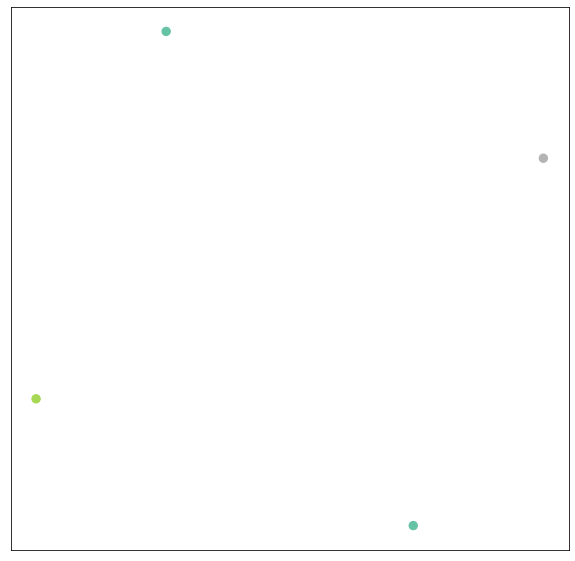

In [ ]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

h = torch.ones(4,10)
y = [0,1,0,2]
visualize(h, y)

In [ ]:
DATASET= 'mr'

if DATASET=='mr':
  MIN_COUNT = [1]

elif DATASET=='20ng':
  MIN_COUNT = [10,20]

else:
   MIN_COUNT = [5]

print(MIN_COUNT)

[1]
